In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib

from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from skimage.measure import label
from skimage.morphology import binary_dilation, closing
from scipy.stats import ttest_ind, false_discovery_control

In [5]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Volumes/Aidan_NYGC/mouse_colon/csplotch_anndata'
adata = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_lambdas.h5ad'))

In [6]:
# Label each spot with the ST array it comes from
adata.obs['array'] = [Path(c).name.split('_stdata')[0] for c in adata.obs.index]

### Fig5a: cellular composition of MROIs across time

In [7]:
# Groups cells of same morphological type together
sntypes_map = {
    'Colonocyte': ['Colonocyte'],
    'Immune': ['B', 'T'],
    'Interstitial': ['Fibroblast', 'Glia', 'Lymphatic', 'Macrophage', 'Mesothelial', 'Neuron', 'Vascular'],
    'Muscle': ['SMC'],
    'Epithelial': ['Cycling', 'Enteroendocrine', 'Goblet', 'Stem', 'TA', 'Tuft']
}
sntypes_ordered = (sntypes_map['Immune'] + sntypes_map['Interstitial'] + 
                   sntypes_map['Muscle'] + sntypes_map['Epithelial'] + sntypes_map['Colonocyte'])

# Set colors for each snRNA-seq cell type, ensuring that those sharing a morphological type are drawn from the same colormap.
colors_ordered = []
for snt in sntypes_ordered:
    if snt == 'Colonocyte':
        cmap = matplotlib.cm.get_cmap('Blues')
        colors_ordered.append(cmap(0.75))
    elif snt == 'SMC':
        cmap = matplotlib.cm.get_cmap('Reds')
        colors_ordered.append(cmap(0.75))
    elif snt == 'B' or snt == 'T':
        cmap = matplotlib.cm.get_cmap('Oranges')
        colors_ordered.append(cmap(0.5 * (sntypes_map['Immune'].index(snt)+1) / len(sntypes_map['Immune'])))
    elif snt in sntypes_map['Interstitial']:
        cmap = matplotlib.cm.get_cmap('Greens')
        colors_ordered.append(cmap(0.75 * (sntypes_map['Interstitial'].index(snt)+1) / len(sntypes_map['Interstitial'])))
    elif snt in sntypes_map['Epithelial']:
        cmap = matplotlib.cm.get_cmap('Purples')
        colors_ordered.append(cmap(0.75 * (sntypes_map['Epithelial'].index(snt)+1) / len(sntypes_map['Epithelial'])))
    else:
        raise ValueError('Unrecognized cell type')

/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_39407/1952167200.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Oranges')
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_39407/1952167200.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greens')
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_39407/1952167200.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplo

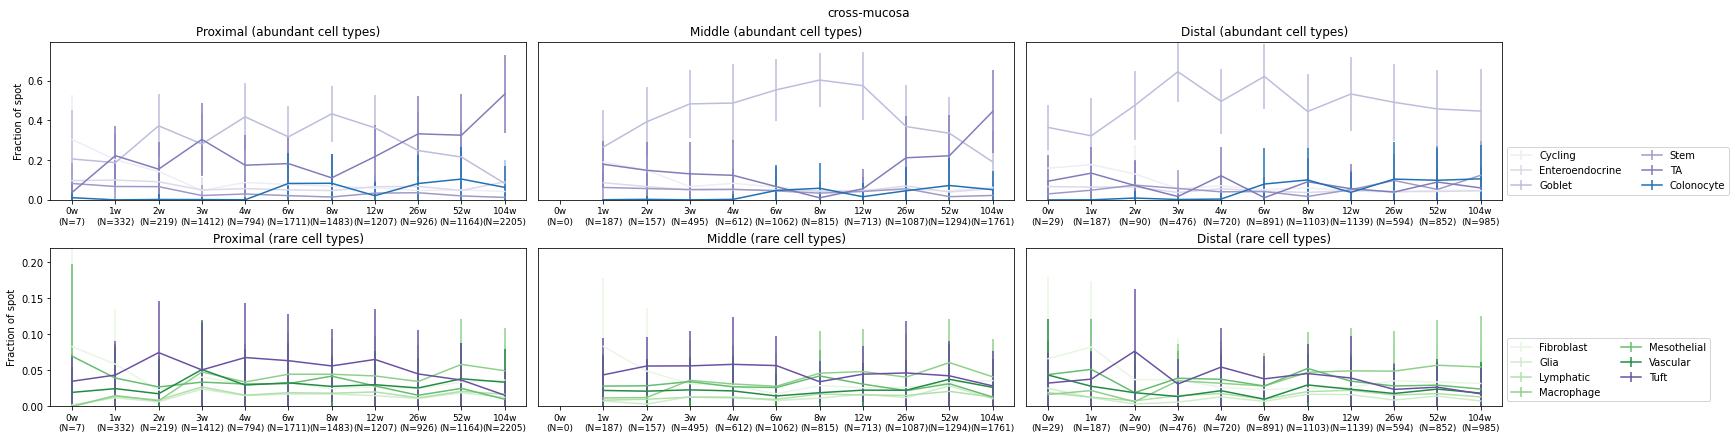

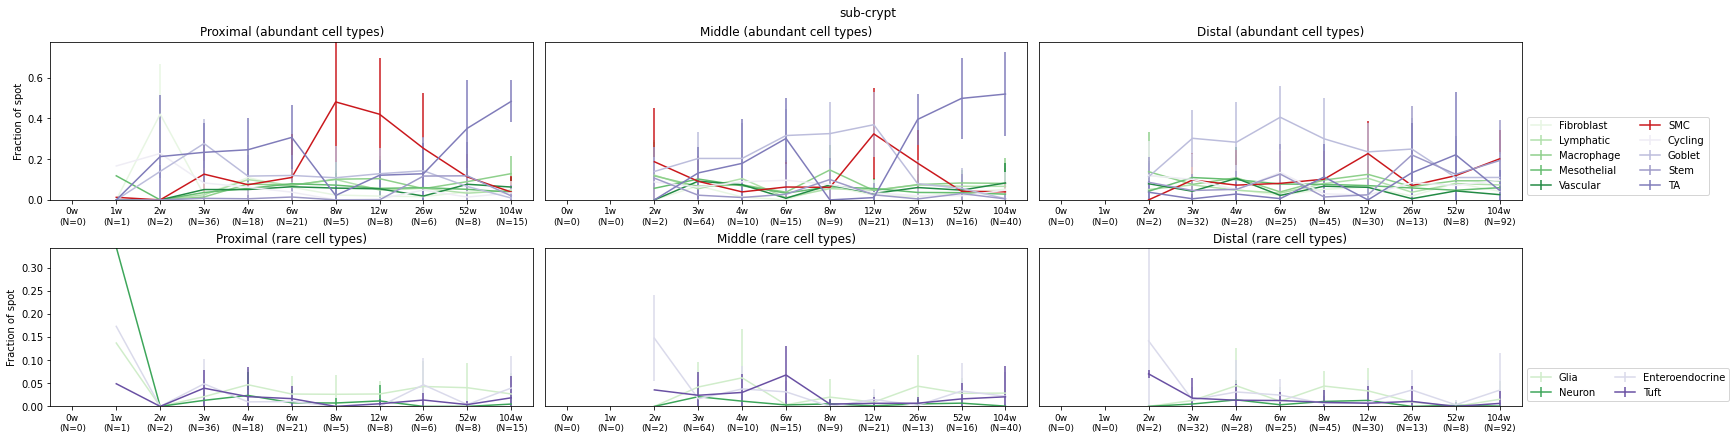

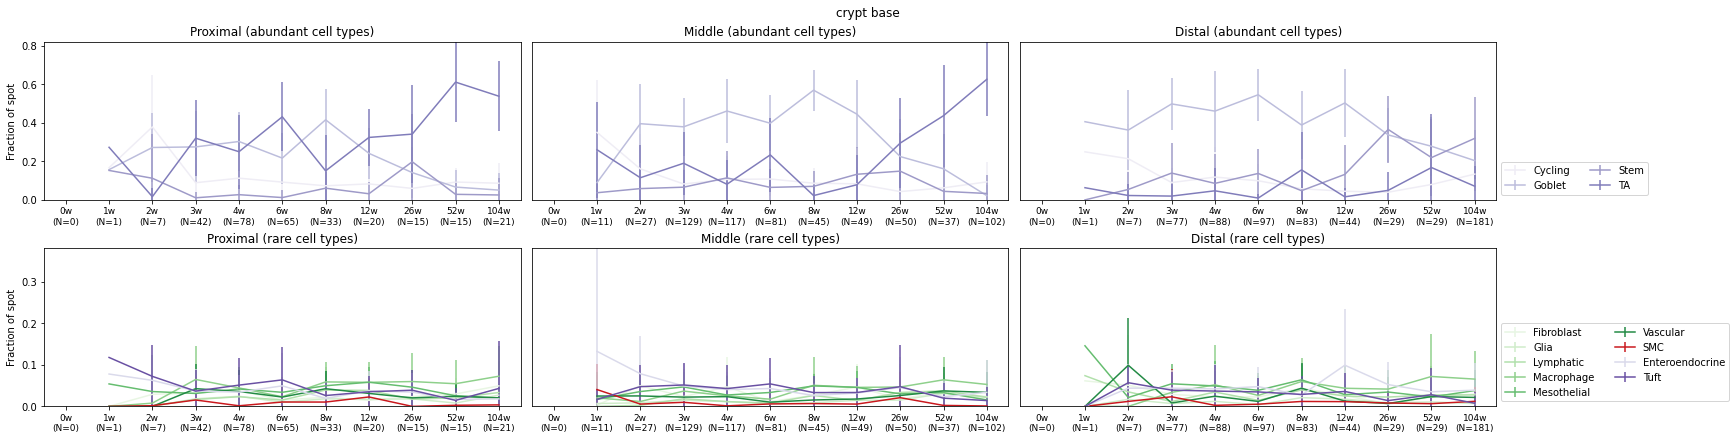

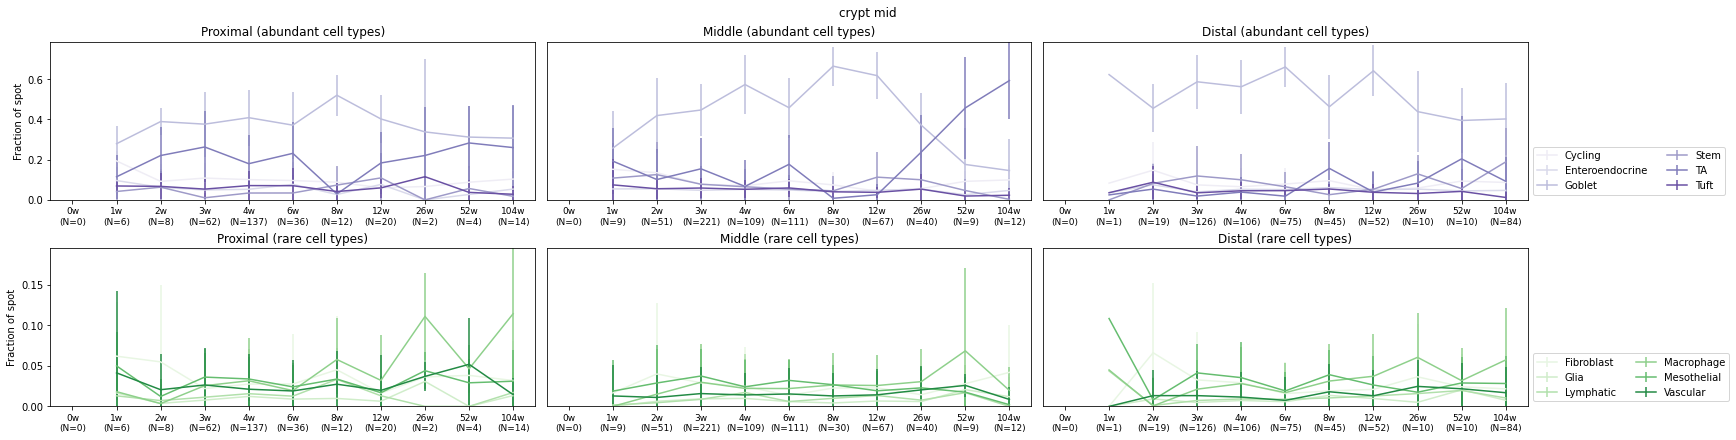

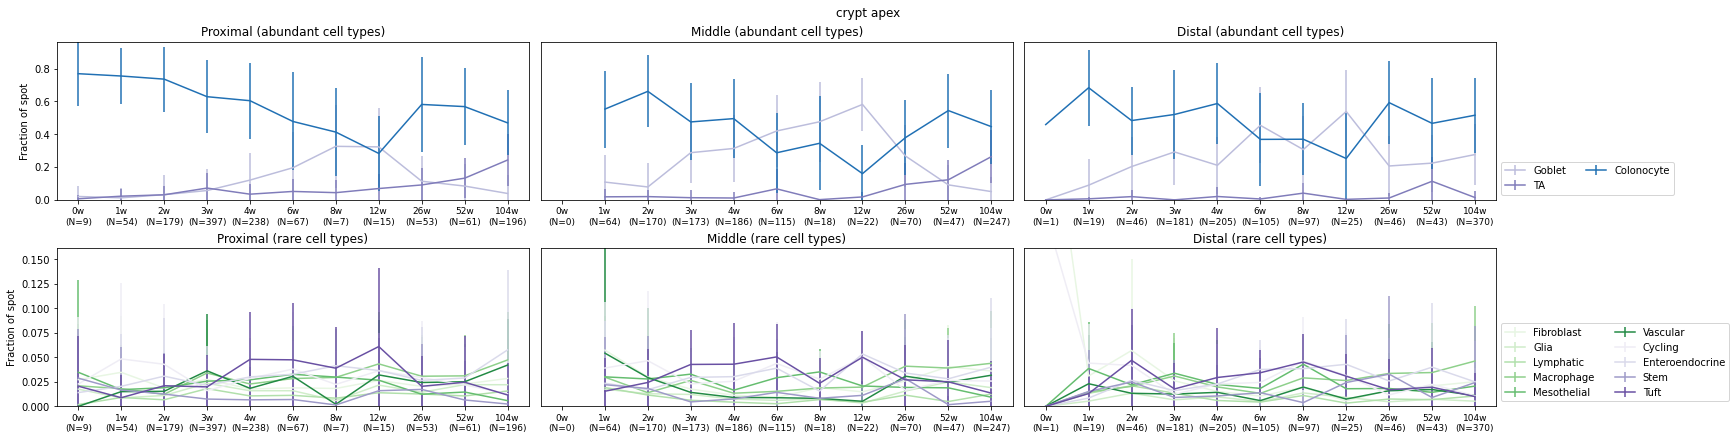

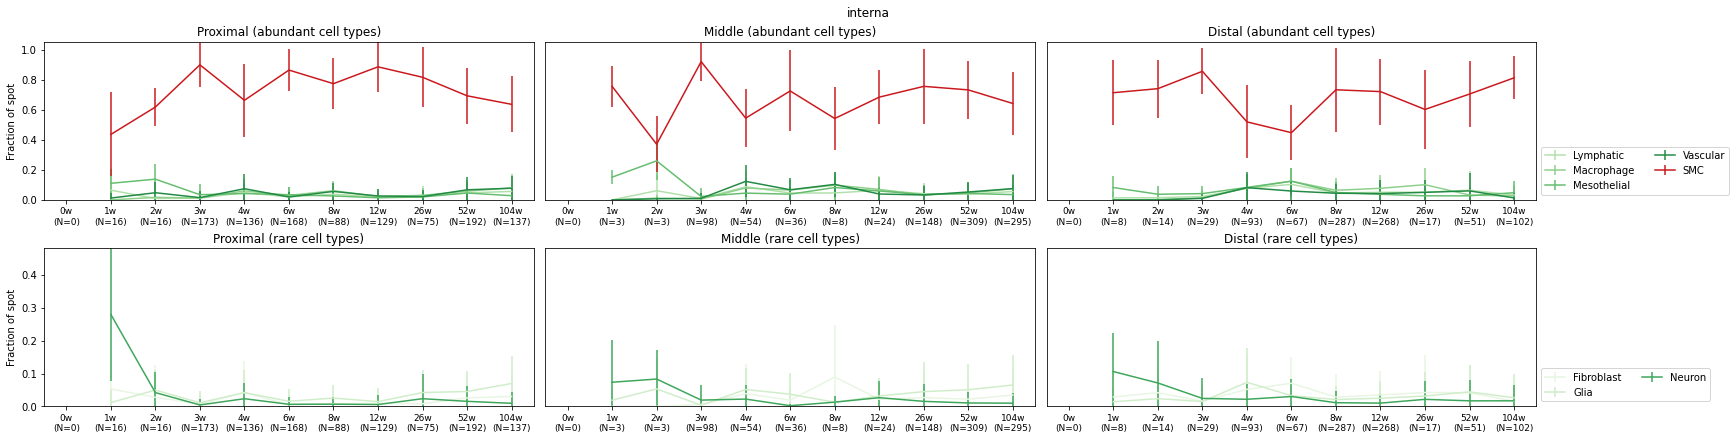

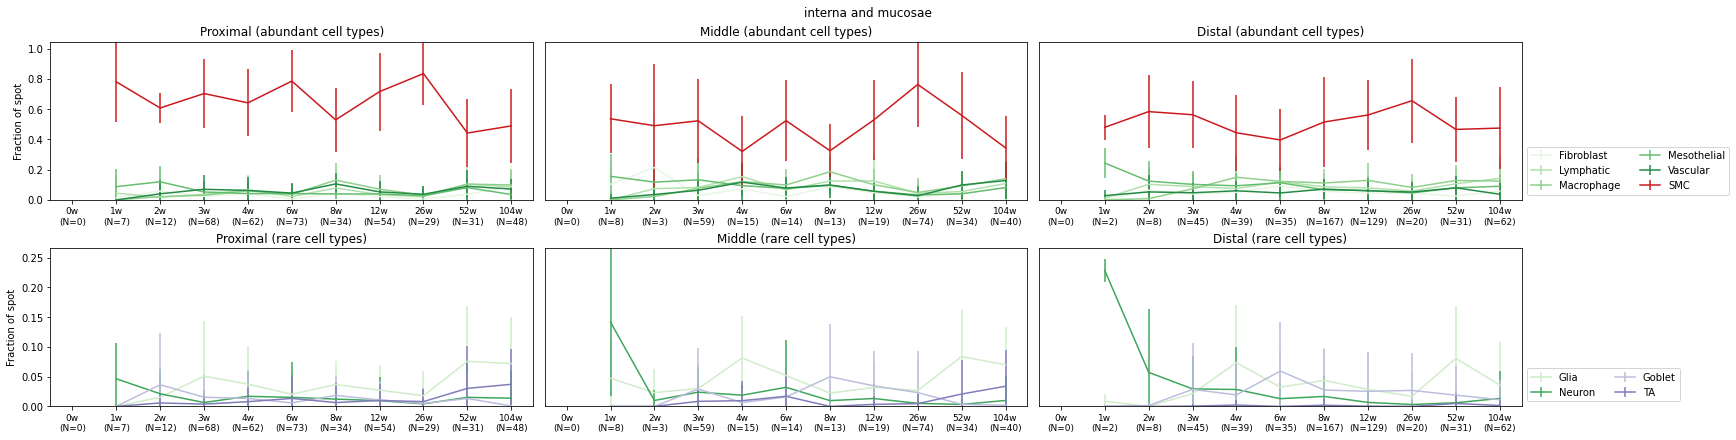

In [4]:
# Proportions of abundant (>5%), rare (1-5%) cell types across full age range

t_ordered = ['0w', '1w', '2w', '3w', '4w', '6w', '8w', '12w', '26w', '52w', '104w']
abundant_thresh = 0.05
rare_thresh = 0.01

for aar in ['cross-mucosa', 'sub-crypt', 'crypt base', 'crypt mid', 'crypt apex',
            'interna', 'interna and mucosae']:
    obs_aar = adata.obs[adata.obs.annotation == aar]
    
    fig, ax = plt.subplots(2, 3, figsize=(24,6), constrained_layout=True)
    
    aar_title = aar
    plt.suptitle(aar_title)
    
    ymax = np.zeros((2,3))
        
    for i, region in enumerate(['Proximal', 'Middle', 'Distal']):
        obs_aar_reg = obs_aar[obs_aar.Region == region]

        celltype_means = dict([(ct, []) for ct in sntypes_ordered])
        celltype_stds = dict([(ct, []) for ct in sntypes_ordered])
        
        x_labels = []

        for t in t_ordered:
            obs_aar_reg_t = obs_aar_reg[obs_aar_reg.Age == t]
            for ct in sntypes_ordered:
                celltype_means[ct].append(obs_aar_reg_t[ct].mean())
                celltype_stds[ct].append(obs_aar_reg_t[ct].std())

            x_labels.append('%s\n(N=%d)' % (t, obs_aar_reg_t.shape[0]))

        for j, thresh in enumerate(['abundant', 'rare']):
            ax[j,i].set_title('%s (%s cell types)' % (region, thresh))

            for ct, col in zip(sntypes_ordered, colors_ordered):
                mean_comp = np.max([obs_aar[ct][obs_aar.Region==r].mean() for r in ['Proximal', 'Middle', 'Distal']])
                
                ct_lbl = ct
                if ct == 'Myocyte':
                    ct_lbl = 'SMC'
                
                if ((thresh == 'abundant' and mean_comp > abundant_thresh) or
                    (thresh == 'rare' and mean_comp > rare_thresh and mean_comp < abundant_thresh)):
                    ax[j,i].errorbar(np.arange(len(t_ordered)), celltype_means[ct], yerr=celltype_stds[ct], 
                                   label=ct_lbl, color=col)
                    
                    inds = np.logical_not(np.isnan(celltype_stds[ct]))
                    mu = np.array(celltype_means[ct])[inds]
                    sigma = np.array(celltype_stds[ct])[inds]
                    ymax[j,i] = np.maximum(ymax[j,i], np.max(mu+sigma))

            ax[j,i].set_xticks(np.arange(len(t_ordered)))
            ax[j,i].set_xticklabels(x_labels, fontsize=9)
            
            if i == 2:
                ax[j,i].legend(bbox_to_anchor=(1.0, 0), loc='lower left', ncol=2)
               
            if i == 0:
                ax[j,i].set_ylabel('Fraction of spot')
            else:
                ax[j,i].set_yticks([])
            
    for j in range(2):
        for i in range(3):
            ax[j,i].set_ylim(0, np.max(ymax[j,:]))
    
    plt.show()

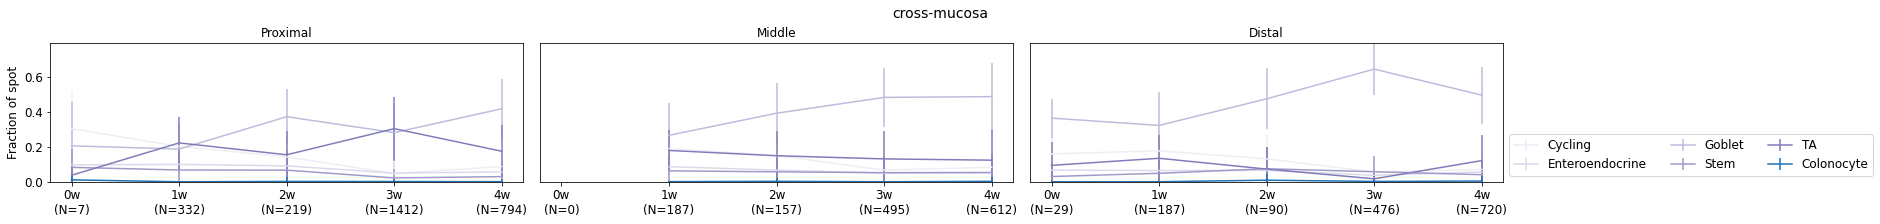

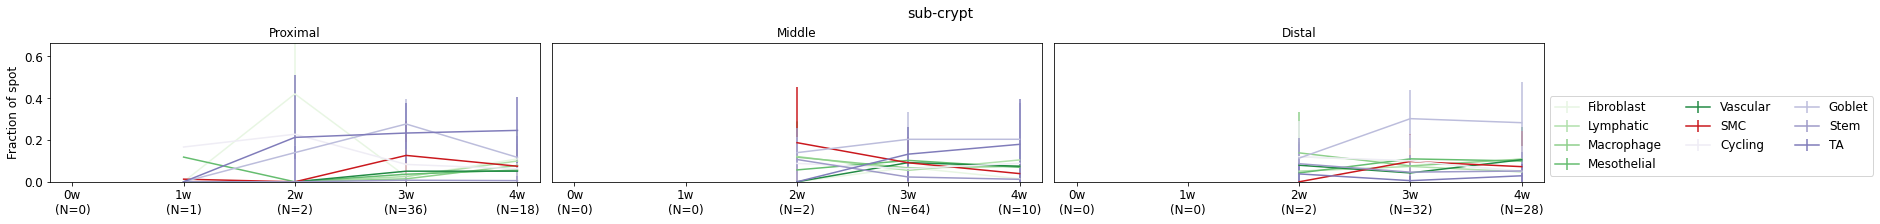

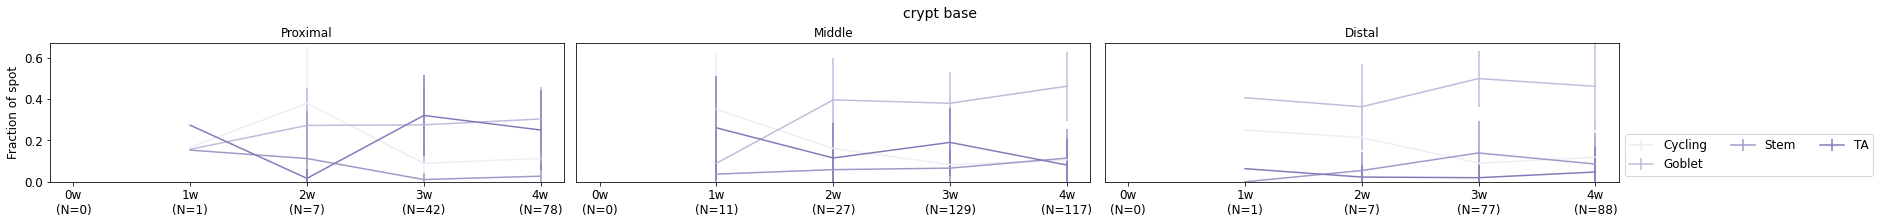

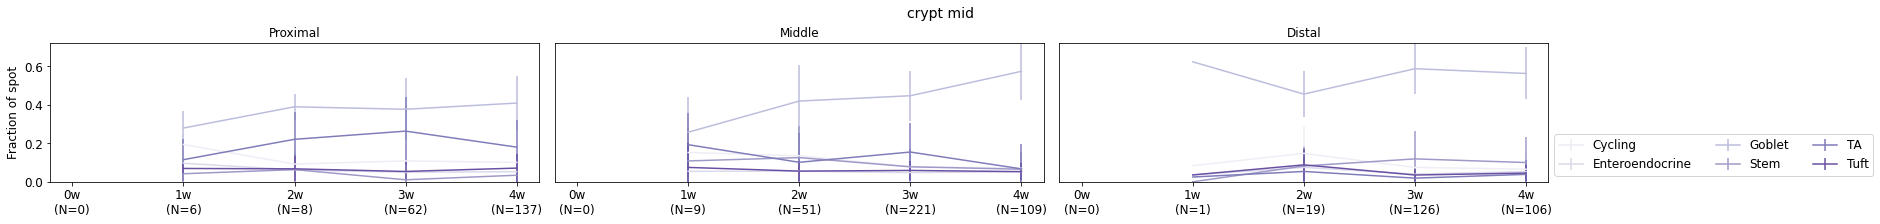

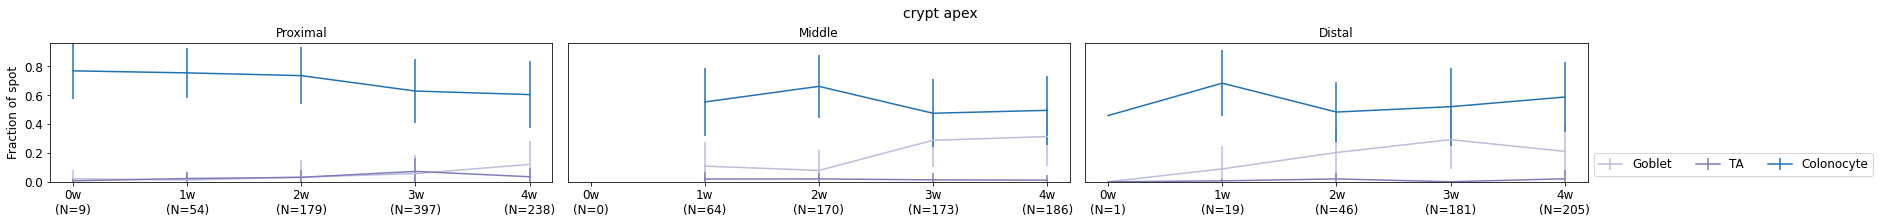

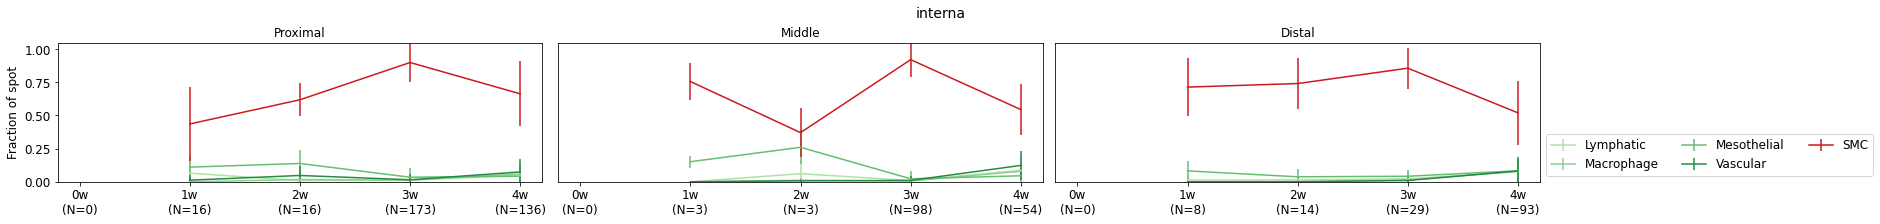

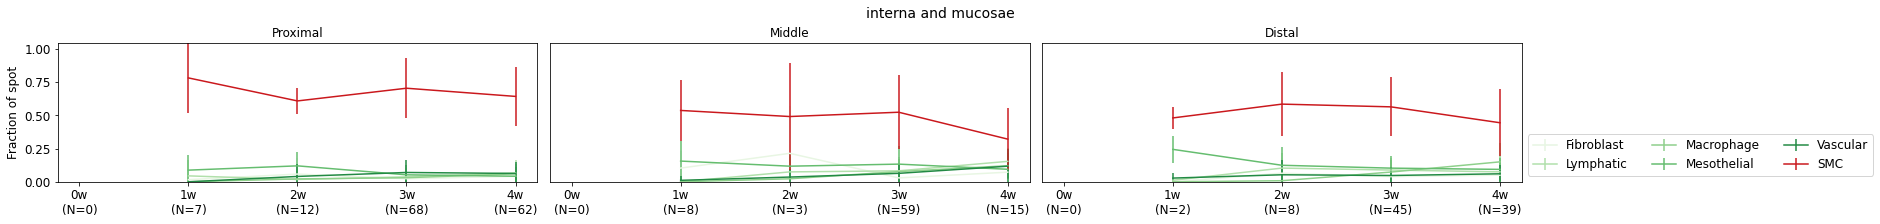

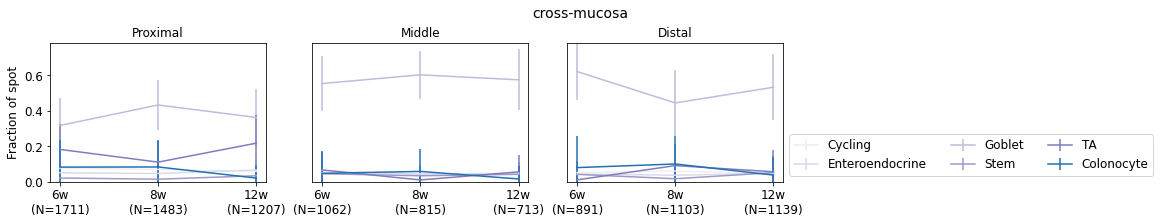

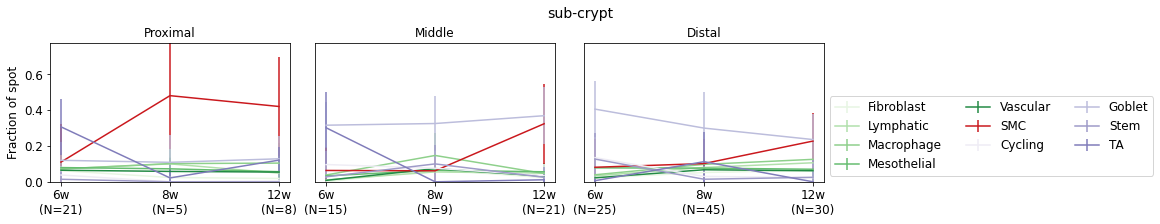

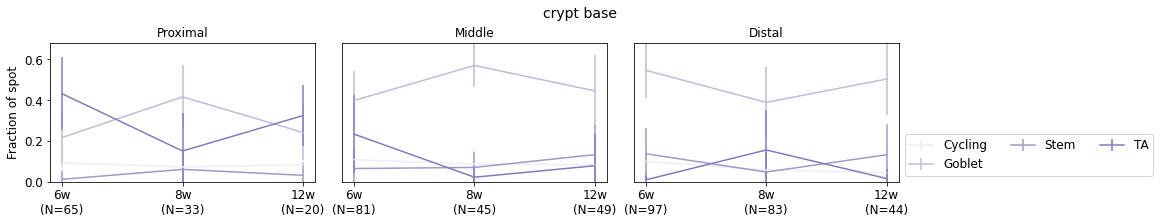

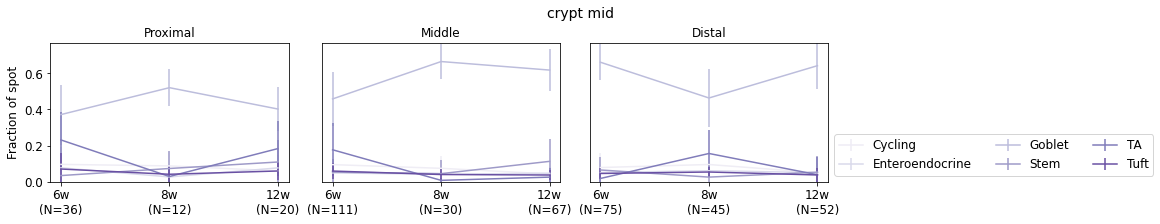

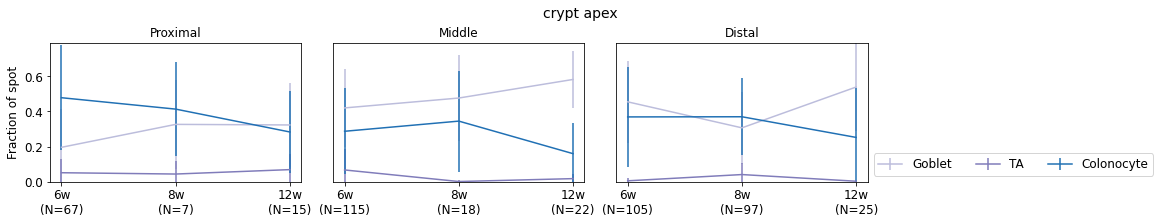

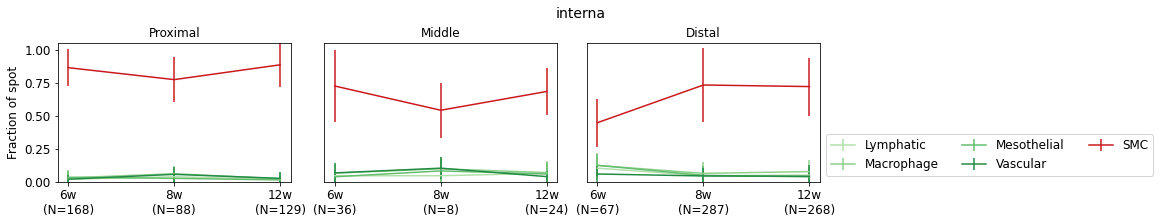

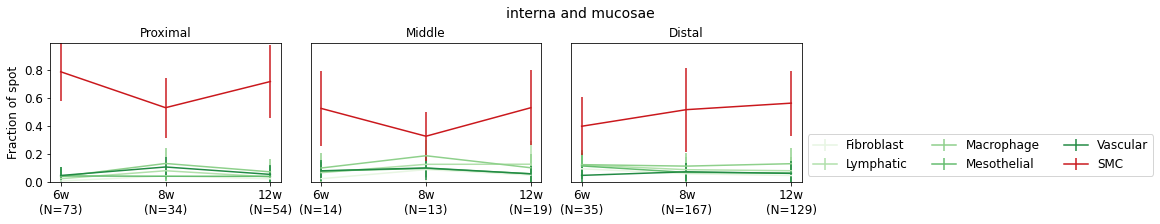

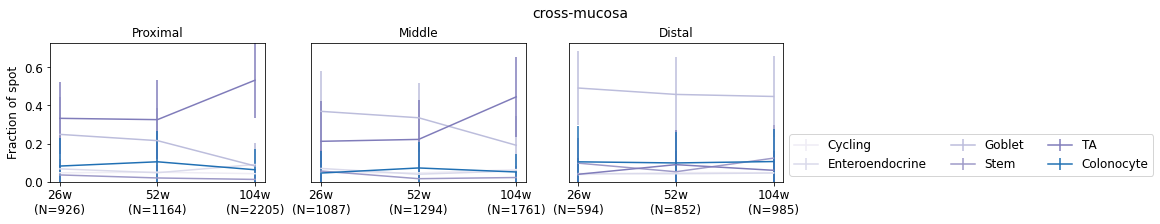

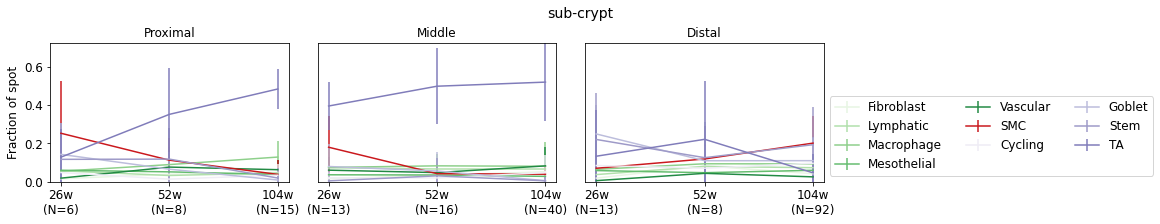

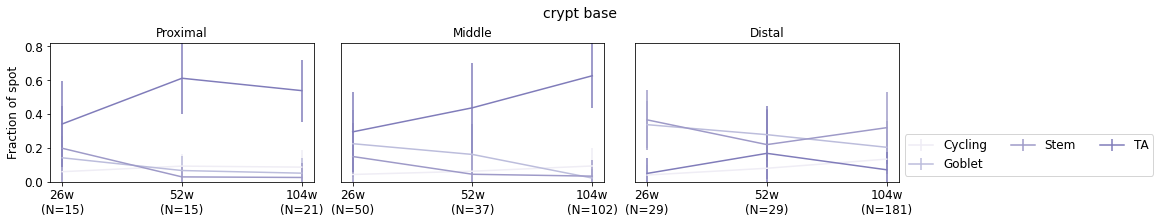

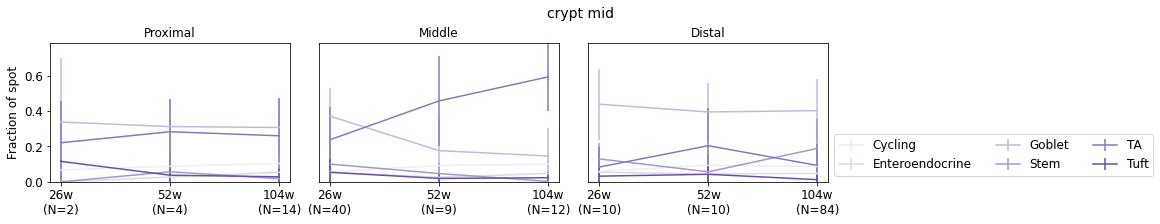

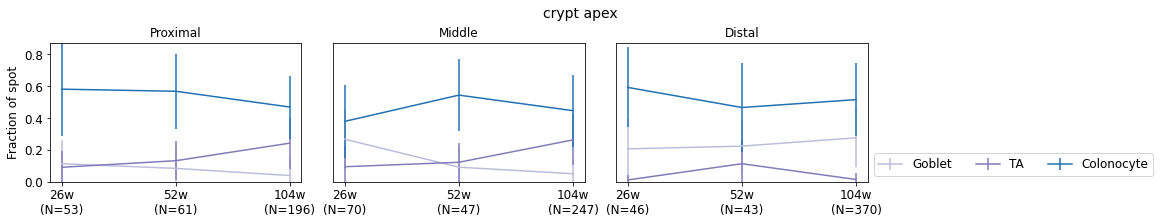

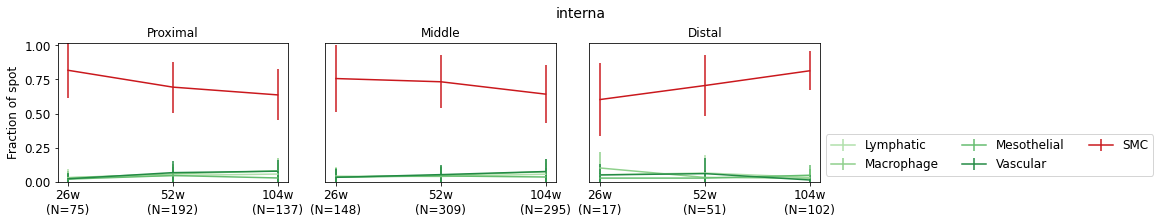

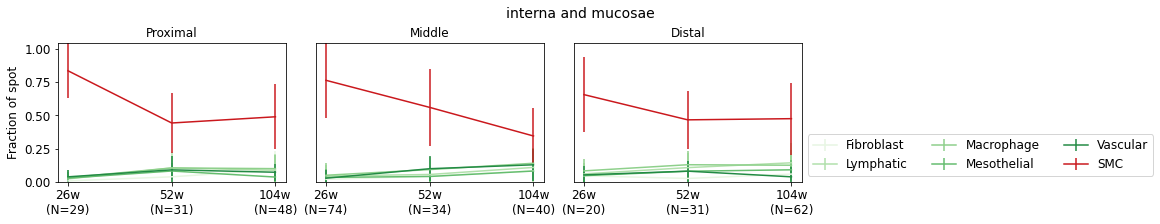

In [5]:
# As above, but restricted to abundant cell types (>5%) and separated into age windows

for t_ordered in [['0w', '1w', '2w', '3w', '4w'], ['6w', '8w', '12w'], ['26w', '52w', '104w']]:
    abundant_thresh = 0.05
    
    t_name = t_ordered[0]+'-'+t_ordered[-1]

    for aar in ['cross-mucosa', 'sub-crypt', 'crypt base', 'crypt mid', 'crypt apex',
            'interna', 'interna and mucosae']:
        obs_aar = adata.obs[adata.obs.annotation == aar]

        fig, ax = plt.subplots(1, 3, figsize=(5*len(t_ordered)+1,3), constrained_layout=True)

        aar_title = aar
        plt.suptitle(aar_title, fontsize=14)

        ymax = np.zeros(3)

        for i, region in enumerate(['Proximal', 'Middle', 'Distal']):
            obs_aar_reg = obs_aar[obs_aar.Region == region]

            celltype_means = dict([(ct, []) for ct in sntypes_ordered])
            celltype_stds = dict([(ct, []) for ct in sntypes_ordered])

            x_labels = []

            for t in t_ordered:
                obs_aar_reg_t = obs_aar_reg[obs_aar_reg.Age == t]
                for ct in sntypes_ordered:
                    celltype_means[ct].append(obs_aar_reg_t[ct].mean())
                    celltype_stds[ct].append(obs_aar_reg_t[ct].std())

                x_labels.append('%s\n(N=%d)' % (t, obs_aar_reg_t.shape[0]))

            ax[i].set_title(region, fontsize=12)

            for ct, col in zip(sntypes_ordered, colors_ordered):
                mean_comp = np.max([obs_aar[ct][obs_aar.Region==r].mean() for r in ['Proximal', 'Middle', 'Distal']])

                ct_lbl = ct
                if ct == 'Myocyte':
                    ct_lbl = 'SMC'

                if mean_comp > abundant_thresh:
                    ax[i].errorbar(np.arange(len(t_ordered)), celltype_means[ct], yerr=celltype_stds[ct], 
                                   label=ct_lbl, color=col)

                    inds = np.logical_not(np.isnan(celltype_stds[ct]))
                    mu = np.array(celltype_means[ct])[inds]
                    sigma = np.array(celltype_stds[ct])[inds]
                    ymax[i] = np.maximum(ymax[i], np.max(mu+sigma))

            ax[i].set_xticks(np.arange(len(t_ordered)))
            ax[i].set_xticklabels(x_labels, fontsize=12)

            if i == 2:
                ax[i].legend(bbox_to_anchor=(1.0, 0), loc='lower left', ncol=3, fontsize=12)

            if i == 0:
                ax[i].set_ylabel('Fraction of spot', fontsize=12)
            else:
                ax[i].set_yticks([])

            ax[i].tick_params(axis='both', which='major', labelsize=12)

        for i in range(3):
            ax[i].set_ylim(0, np.max(ymax))

        plt.show()

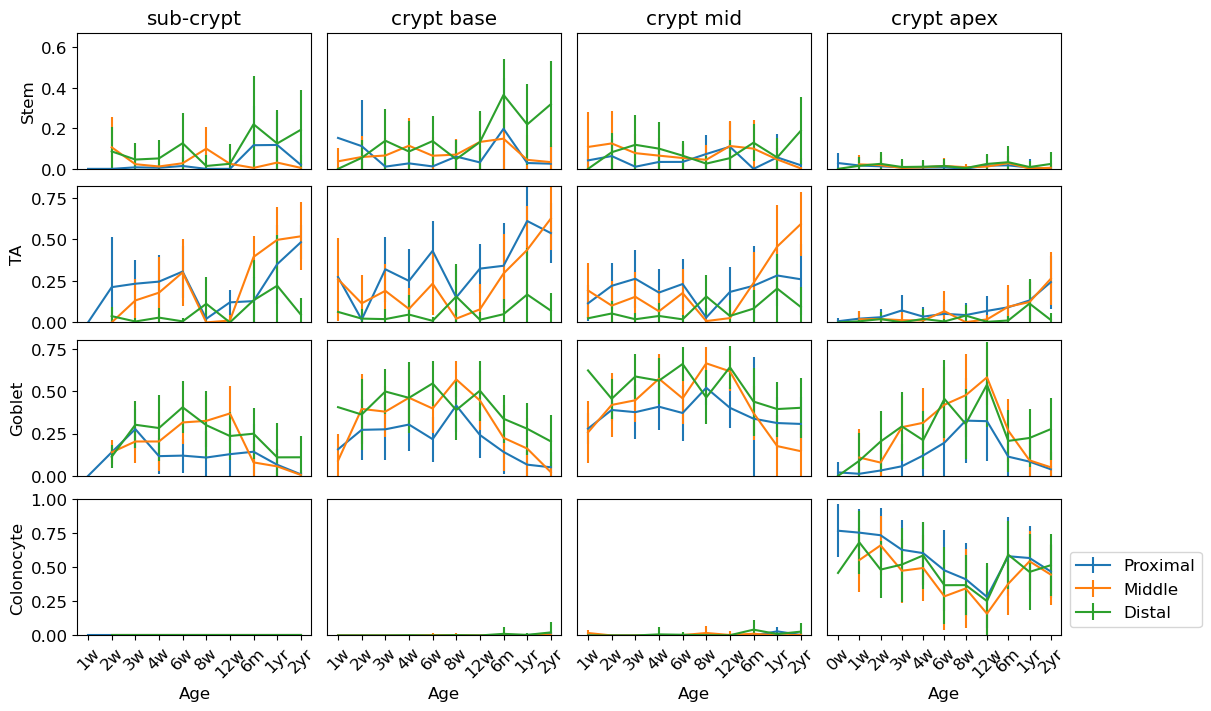

In [16]:
# Try separate plots per cell type, with colored lines indicating trajectories in P/M/D colon
t_ordered = ['0w', '1w', '2w', '3w', '4w', '6w', '8w', '12w', '26w', '52w', '104w']
t_labels = ['0w', '1w', '2w', '3w', '4w', '6w', '8w', '12w', '6m', '1yr', '2yr']

crypt_mrois = ['sub-crypt', 'crypt base', 'crypt mid', 'crypt apex']
abund_thresh = 0.05

# List of all cell types abundant in at least one MROI
#abund_ct = ['TA', 'Stem', 'Fibroblast', 'Lymphatic', 'Vascular', 'SMC', 'Goblet', 'Cycling', 
#            'Colonocyte', 'Enteroendocrine', 'Tuft']
abund_ct = ['Stem', 'TA', 'Goblet', 'Colonocyte']
            
# Find range of values for each abundant celltypes across crypt mrois
ct_range = {}
obs_crypt = adata.obs[adata.obs.annotation.isin(crypt_mrois)]
for ct in abund_ct:
    # Set ylim for each ctype to 99th percentile in most abundant MROI
    ct_range[ct] = (0,0)
    for mroi in crypt_mrois:
        t = np.percentile(obs_crypt[ct][obs_crypt['annotation']==mroi], 99)
        if t > ct_range[ct][1]:
            ct_range[ct] = (0, t)
            
# Track mean/var of predicted fraction of each abundant cell type in each MROI + region
fig, ax = plt.subplots(len(abund_ct), len(crypt_mrois), figsize=(12,7),
                      constrained_layout=True)
plt.rcParams.update({'font.size': 12})

for j, mroi in enumerate(crypt_mrois):
    obs_mroi = adata.obs[adata.obs.annotation == mroi] 
    
    ax[0,j].set_title(mroi)
            
    for i, ct in enumerate(abund_ct):
        celltype_means, celltype_stds = {}, {}
        
        ax[i,j].set_ylim(ct_range[ct])
        if j==0:
            ax[i,j].set_ylabel(ct)
        else:
            ax[i,j].set_yticks([])
        
        if i < len(abund_ct)-1:
            ax[i,j].set_xticks([])
        else:
            ax[i,j].set_xlabel('Age')
            ax[i,j].set_xticks(np.arange(len(t_ordered)))
            ax[i,j].set_xticklabels(t_labels, rotation=45)
        
        for reg in ['Proximal', 'Middle', 'Distal']:
            obs_reg = obs_mroi[obs_mroi.Region == reg]
            celltype_means[reg] = []
            celltype_stds[reg] = []
            
            for t in t_ordered:
                obs_t = obs_reg[obs_reg.Age == t]
                celltype_means[reg].append(obs_t[ct].mean())
                celltype_stds[reg].append(obs_t[ct].std())
        
        for reg in ['Proximal', 'Middle', 'Distal']:
            ax[i,j].errorbar(np.arange(len(t_ordered)), celltype_means[reg], 
                             yerr=celltype_stds[reg], label=reg)
            
ax[-1, -1].legend(bbox_to_anchor=(1.0, 0), loc='lower left')

plt.savefig(os.path.join('fig4_v2', 'cell_abundance_main.svg'))

In [13]:
# Significance of change in cell composition between Xm (3? 6?) and 2yr
ref_t = '104w'
query_t = ['12w', '26w']
regions = ['Proximal', 'Middle', 'Distal']

df_sig = pd.DataFrame(index=pd.MultiIndex.from_product([regions, crypt_mrois + extra_mrois, abund_ct], 
                                                       names=['Region', 'MROI', 'celltype']),
                      columns=['p_adj(12w)', 'p_adj(26w)'])

for mroi in crypt_mrois + extra_mrois:
    for reg in regions:
        obs_niche = obs_crypt.loc[obs_crypt.annotation==mroi]
        obs_niche = obs_niche.loc[obs_niche.Region==reg]
        
        obs_ref_t = obs_niche[obs_niche.Age==ref_t]
        
        for t in query_t:
            obs_t = obs_niche[obs_niche.Age==t]
            
            for ct in abund_ct:
                r = [df_arr[ct].values.mean() for arr,df_arr in obs_ref_t.groupby('array')]
                q = [df_arr[ct].values.mean() for arr,df_arr in obs_t.groupby('array')]
                
                if len(r) > 3 and len(q) > 3:
                    res = ttest_ind(q, r, equal_var=False)
                    df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
                    
df_sig = df_sig.fillna(1)
for t in query_t:
    df_sig['p_adj(%s)' % t] = false_discovery_control(df_sig['p_adj(%s)' % t])
    
df_sig.to_csv(os.path.join('fig4_v2', 'fig4b_sigchanges.csv'))

/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_39407/1364491001.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_39407/1364491001.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_39407/1364491001.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_39407/1364491001.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/2y/rfyy59b10y1bdnyzxhgdcf9w0000gn/T/ipykernel_39407/1364491001.py:26: PerformanceWarning: indexing past lexsort depth may impac

/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performa

/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performa

/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_sig.loc[(reg, mroi, ct), 'p_adj(%s)' % t] = res.pvalue
/var/folders/cz/tz9nr4710px51vhl4kq588jr0001bz/T/ipykernel_32559/47830270.py:26: PerformanceWarning: indexing past lexsort depth may impact performa

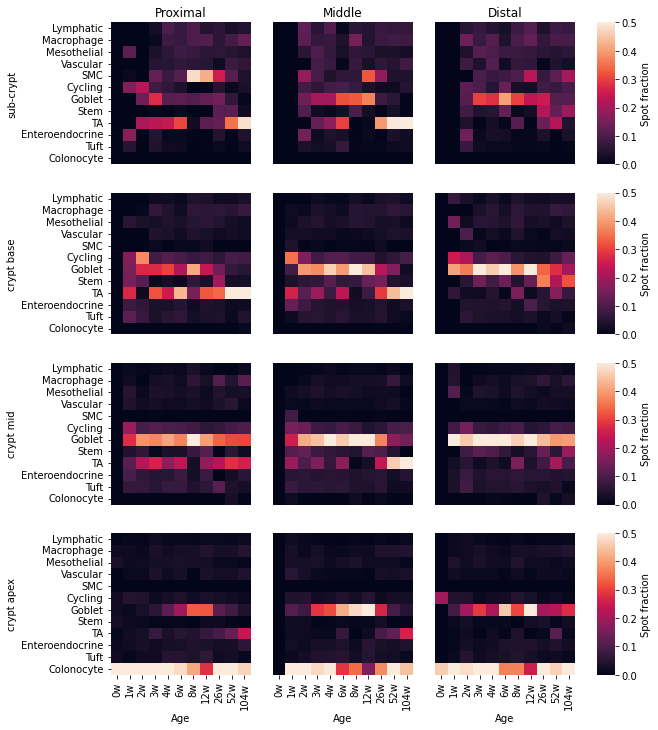

In [50]:
# Plots per MROI and colon region as before, but replacing line plots with (celltypes, ages) heatmaps
fig, ax = plt.subplots(len(crypt_mrois), 4, figsize=(10,12), gridspec_kw={'width_ratios':[8,8,8,1]})

for i, mroi in enumerate(crypt_mrois):
    obs_mroi = adata.obs[adata.obs.annotation == mroi]
    
    for j, reg in enumerate(['Proximal', 'Middle', 'Distal']):
        obs_reg = obs_mroi[obs_mroi.Region == reg]
        
        df_ct = pd.DataFrame(index=abund_ct, columns=t_ordered, dtype=np.float64)

        for ct in abund_ct:
            for t in t_ordered:
                df_ct.loc[ct, t] = obs_reg[ct][obs_reg.Age==t].mean()
         
        # Default to 0 for unmeasured conditions
        df_ct = df_ct.fillna(0)
        
        if j==0:
            yticklabels = True
        else:
            yticklabels = False
            
        if i<len(crypt_mrois)-1:
            xticklabels = False
        else:
            xticklabels = True
            
        if j==2:
            cbar = True
        else:
            cbar = False
            
        sns.heatmap(df_ct, ax=ax[i,j], 
                    yticklabels=yticklabels, 
                    xticklabels=xticklabels, 
                    cbar=cbar, cbar_ax=ax[i,-1],
                    cbar_kws={'label': 'Spot fraction'},
                    vmin=0, vmax=0.5
                   )
        
        if j==0:
            ax[i,j].set_ylabel(mroi)
        if i==0:
            ax[i,j].set_title(reg)
        if i==len(crypt_mrois)-1:
            ax[i,j].set_xlabel('Age')
            
plt.subplots_adjust(left=0.2)
plt.savefig('fig4b_alt2.svg')